In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors
import os
import re

### Figure 6
Because the sampling can be time consuming, and we tested 70 total genotypes, the sampling for knockout strategies is performed in a separate step using slurm (sample_knockouts.sh). That step must be run before this notebook

In [2]:
data_path = "b971180d/combined.tsv"

In [3]:
df = pd.read_csv(data_path, sep="\t")
df["Closed"] = [("closed" in x) for x in df.Source]
df["Source"] = df.Source.str.replace("_closed", "")
df["Source"] = df.Source.str.replace("_open", "")
df["Knockins"] = [x.split("d")[0] for x in df.Source]
df["deletions"] = [x.split("d")[1] for x in df.Source]
## experimental
df.TP_ETOH = (df.TP_ETOH/df.MalABC)*df.Biomass
df.TP_ace = (df.TP_ace/df.MalABC)*df.Biomass
### 
yaxisname = "Scaled production flux"
df = df.drop(columns=["Biomass", "MalABC", "Source"]).rename(columns={"TP_ace": "Acetate", "TP_ETOH": "Ethanol"})
df = df.melt(["Knockins","deletions", "Closed"], value_name=yaxisname)
df.deletions = ["Δ" + x.replace("_", " Δ").replace(".csv", "") for x in df.deletions]
df.loc[[x == "Δ" for x in df.deletions]] = df.loc[[x == "Δ" for x in df.deletions]].assign(deletions="No deletions")
df.Knockins = ["+"+x.rstrip("_YM_").replace("_", " +") for x in df.Knockins]
df.loc[df.Knockins == "+"] = df.loc[df.Knockins == "+"].assign(Knockins="None")
df = df[[("NFN1" not in x) or (x == "ΔGAPOR ΔNFN1") for x in df.deletions]] # filter NFN1 strains bc we don't talk about them
## axis sorting order
l = list(set(df.deletions))
l.sort(key=len)
l.insert(0, l.pop(l.index("No deletions")))
l.insert(3, l.pop(l.index("ΔMBH")))

In [4]:
df2 = pd.read_csv(data_path, sep="\t")
df2["Closed"] = [("closed" in x) for x in df2.Source]
df2["Source"] = df2.Source.str.replace("_closed", "")
df2["Source"] = df2.Source.str.replace("_open", "")
df2["Knockins"] = [x.split("d")[0] for x in df2.Source]
df2["deletions"] = [x.split("d")[1] for x in df2.Source]
## experimental
yaxisname = "Scaled production flux"
df2 = df2.drop(columns=["MalABC", "Source"]).rename(columns={"TP_ace": "Acetate", "TP_ETOH": "Ethanol"})
df2 = df2.melt(["Knockins","deletions", "Closed"], value_name=yaxisname)
df2.deletions = ["Δ" + x.replace("_", " Δ").replace(".csv", "") for x in df2.deletions]
df2.loc[[x == "Δ" for x in df2.deletions]] = df2.loc[[x == "Δ" for x in df2.deletions]].assign(deletions="No deletions")
df2.Knockins = ["+"+x.rstrip("_YM_").replace("_", " +") for x in df2.Knockins]
df2.loc[df2.Knockins == "+"] = df2.loc[df2.Knockins == "+"].assign(Knockins="None")
df2 = df2[[("NFN1" not in x) or (x == "ΔGAPOR ΔNFN1") for x in df2.deletions]] # filter NFN1 strains bc we don't talk about them
df2_closed = df2[df2["Closed"]]
df2_open = df2[~df2["Closed"]]

In [5]:
df_closed = df[df["Closed"]]
df_open = df[~df["Closed"]]

In [6]:
df_closed.query('variable == "Ethanol"')[["Knockins", "deletions", "Scaled production flux"]].groupby(["Knockins", "deletions"]).median().sort_values(by="Scaled production flux").tail(5)

Scaled production flux
Knockins    deletions                             
+GAPN +CODH ΔACS ΔAOR ΔMBH                0.329992
            ΔGAPOR ΔNFN1                  0.343961
            ΔGAPOR                        0.384212
            ΔMBH                          0.397094
            ΔGAPOR ΔMBH                   0.441070

In [7]:
base_growth = df2_closed.query('(variable == "Biomass") \
                    and (deletions == "No deletions") \
                    and (Knockins == "None")')["Scaled production flux"].median()
mutant_growth = df2_closed.query('(variable == "Biomass") \
                    and (deletions == "ΔGAPOR ΔMBH") \
                    and (Knockins == "+GAPN +CODH")')["Scaled production flux"].median()
print(mutant_growth/base_growth)
base_etoh = df2_closed.query('(variable == "Ethanol") \
                    and (deletions == "No deletions") \
                    and (Knockins == "None")')["Scaled production flux"].median()
mutant_etoh = df2_closed.query('(variable == "Ethanol") \
                    and (deletions == "ΔGAPOR ΔMBH") \
                    and (Knockins == "+GAPN +CODH")')["Scaled production flux"].median()
print(mutant_etoh, base_etoh, mutant_etoh/base_etoh)

2.0919859638788494
29.065401883845514 7.594918347325437 3.8269538334248114


In [8]:
df_open.query('variable == "Ethanol"')[["Knockins", "deletions", "Scaled production flux"]].groupby(["Knockins", "deletions"]).median().sort_values(by="Scaled production flux").tail(5)

Scaled production flux
Knockins    deletions                                    
+GAPN +CODH ΔGAPOR ΔMBH                          0.275896
            ΔGAPOR                               0.324971
            ΔGAPOR ΔNFN1                         0.351116
            ΔACS ΔAOR ΔGAPOR ΔMBH                0.429221
            ΔACS ΔAOR ΔMBH                       0.453634

In [9]:
base_growth = df2_open.query('(variable == "Biomass") \
                    and (deletions == "No deletions") \
                    and (Knockins == "None")')["Scaled production flux"].median()
mutant_growth = df2_open.query('(variable == "Biomass") \
                    and (deletions == "ΔACS ΔAOR ΔMBH") \
                    and (Knockins == "+GAPN +CODH")')["Scaled production flux"].median()
print(mutant_growth/base_growth)
base_etoh = df2_open.query('(variable == "Ethanol") \
                    and (deletions == "No deletions") \
                    and (Knockins == "None")')["Scaled production flux"].median()
mutant_etoh = df2_open.query('(variable == "Ethanol") \
                    and (deletions == "ΔACS ΔAOR ΔMBH") \
                    and (Knockins == "+GAPN +CODH")')["Scaled production flux"].median()
print(mutant_etoh, base_etoh, mutant_etoh/base_etoh)

2.4939015284724797
14.463625811468575 1.0746575903453133 13.458822550930911


#####
Regex replacing the gene deletion strains to get the latex italic formatting

In [10]:
def replacement(match):
    return r"Δ$\it{"+match.group(1).lower()+r"}$"
df_closed_forfig = df_closed.copy()
df_open_forfig = df_open.copy()
df_closed_forfig.deletions = [re.sub(r"Δ([A-z0-p]+)", replacement, x) for x in df_closed_forfig.deletions]
df_open_forfig.deletions = [re.sub(r"Δ([A-z0-p]+)", replacement, x) for x in df_open_forfig.deletions]

l = list(set(df_closed_forfig.deletions))
l.sort(key=len)
l.insert(0, l.pop(l.index("No deletions")))
l.insert(3, l.pop(l.index("Δ$\it{mbh}$")))

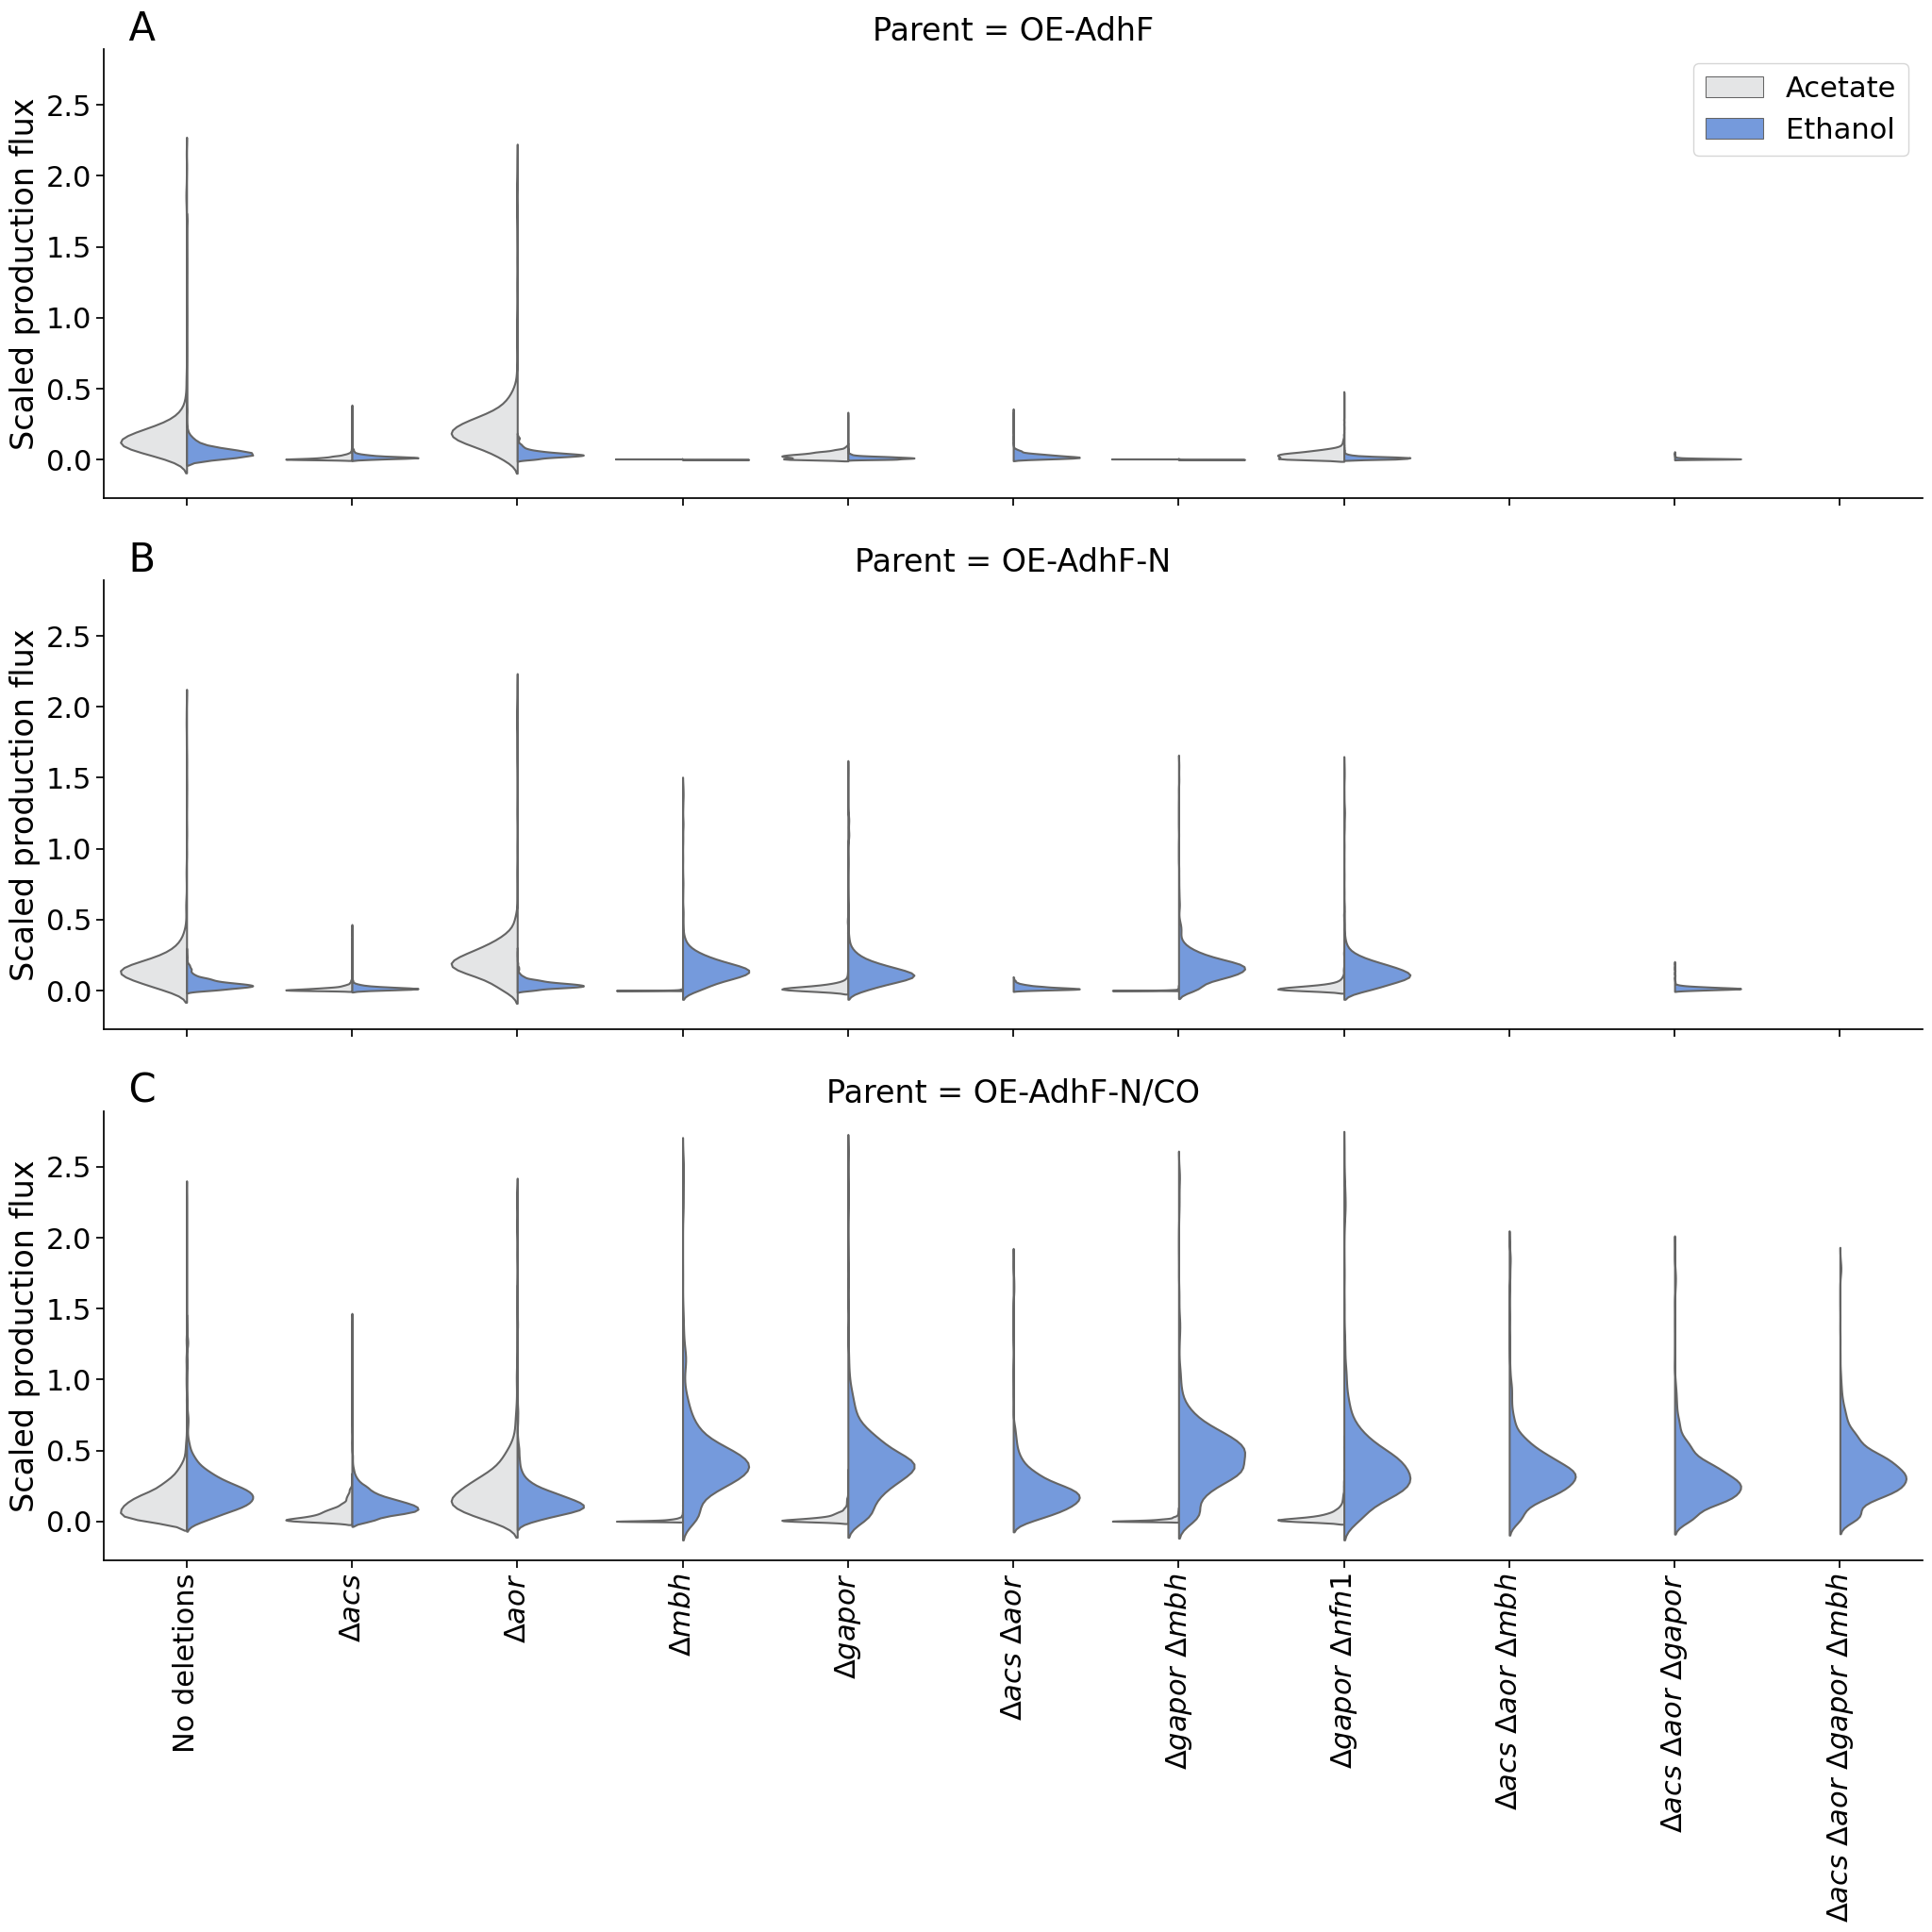

In [11]:
with sns.plotting_context("notebook", font_scale=2):
    g = sns.FacetGrid(df_closed_forfig.sort_values(by="Knockins", key=lambda x: x.str.len()), col="Knockins", col_wrap=1,
                     aspect=3, height=7)
    g.map_dataframe(sns.violinplot, x="deletions", y=yaxisname, hue="variable", hue_order=["Acetate", "Ethanol"], 
                    split=True, inner=None, scale="count", scale_hue=False, order=l, palette=sns.color_palette(["#e4e5e6", mcolors.to_hex("cornflowerblue")]))
    g.axes[0].set_title("  A", loc="left", fontdict={"fontsize": 30, "fontweight": 500})
    g.axes[0].set_title("Parent = OE-AdhF", loc="center")
    g.axes[1].set_title("  B", loc="left", fontdict={"fontsize": 30, "fontweight": 500})
    g.axes[1].set_title("Parent = OE-AdhF-N", loc="center")
    g.axes[2].set_title("  C", loc="left", fontdict={"fontsize": 30, "fontweight": 500})
    g.axes[2].set_title("Parent = OE-AdhF-N/CO", loc="center")
    g.axes[0].legend(loc="upper right")
    plt.xlabel("")
    plt.xticks(rotation="vertical")
    plt.tight_layout()
    plt.savefig("./figures/Fig6.tiff", dpi=300, format="tiff", pil_kwargs={"compression": "tiff_lzw"})
    plt.show()

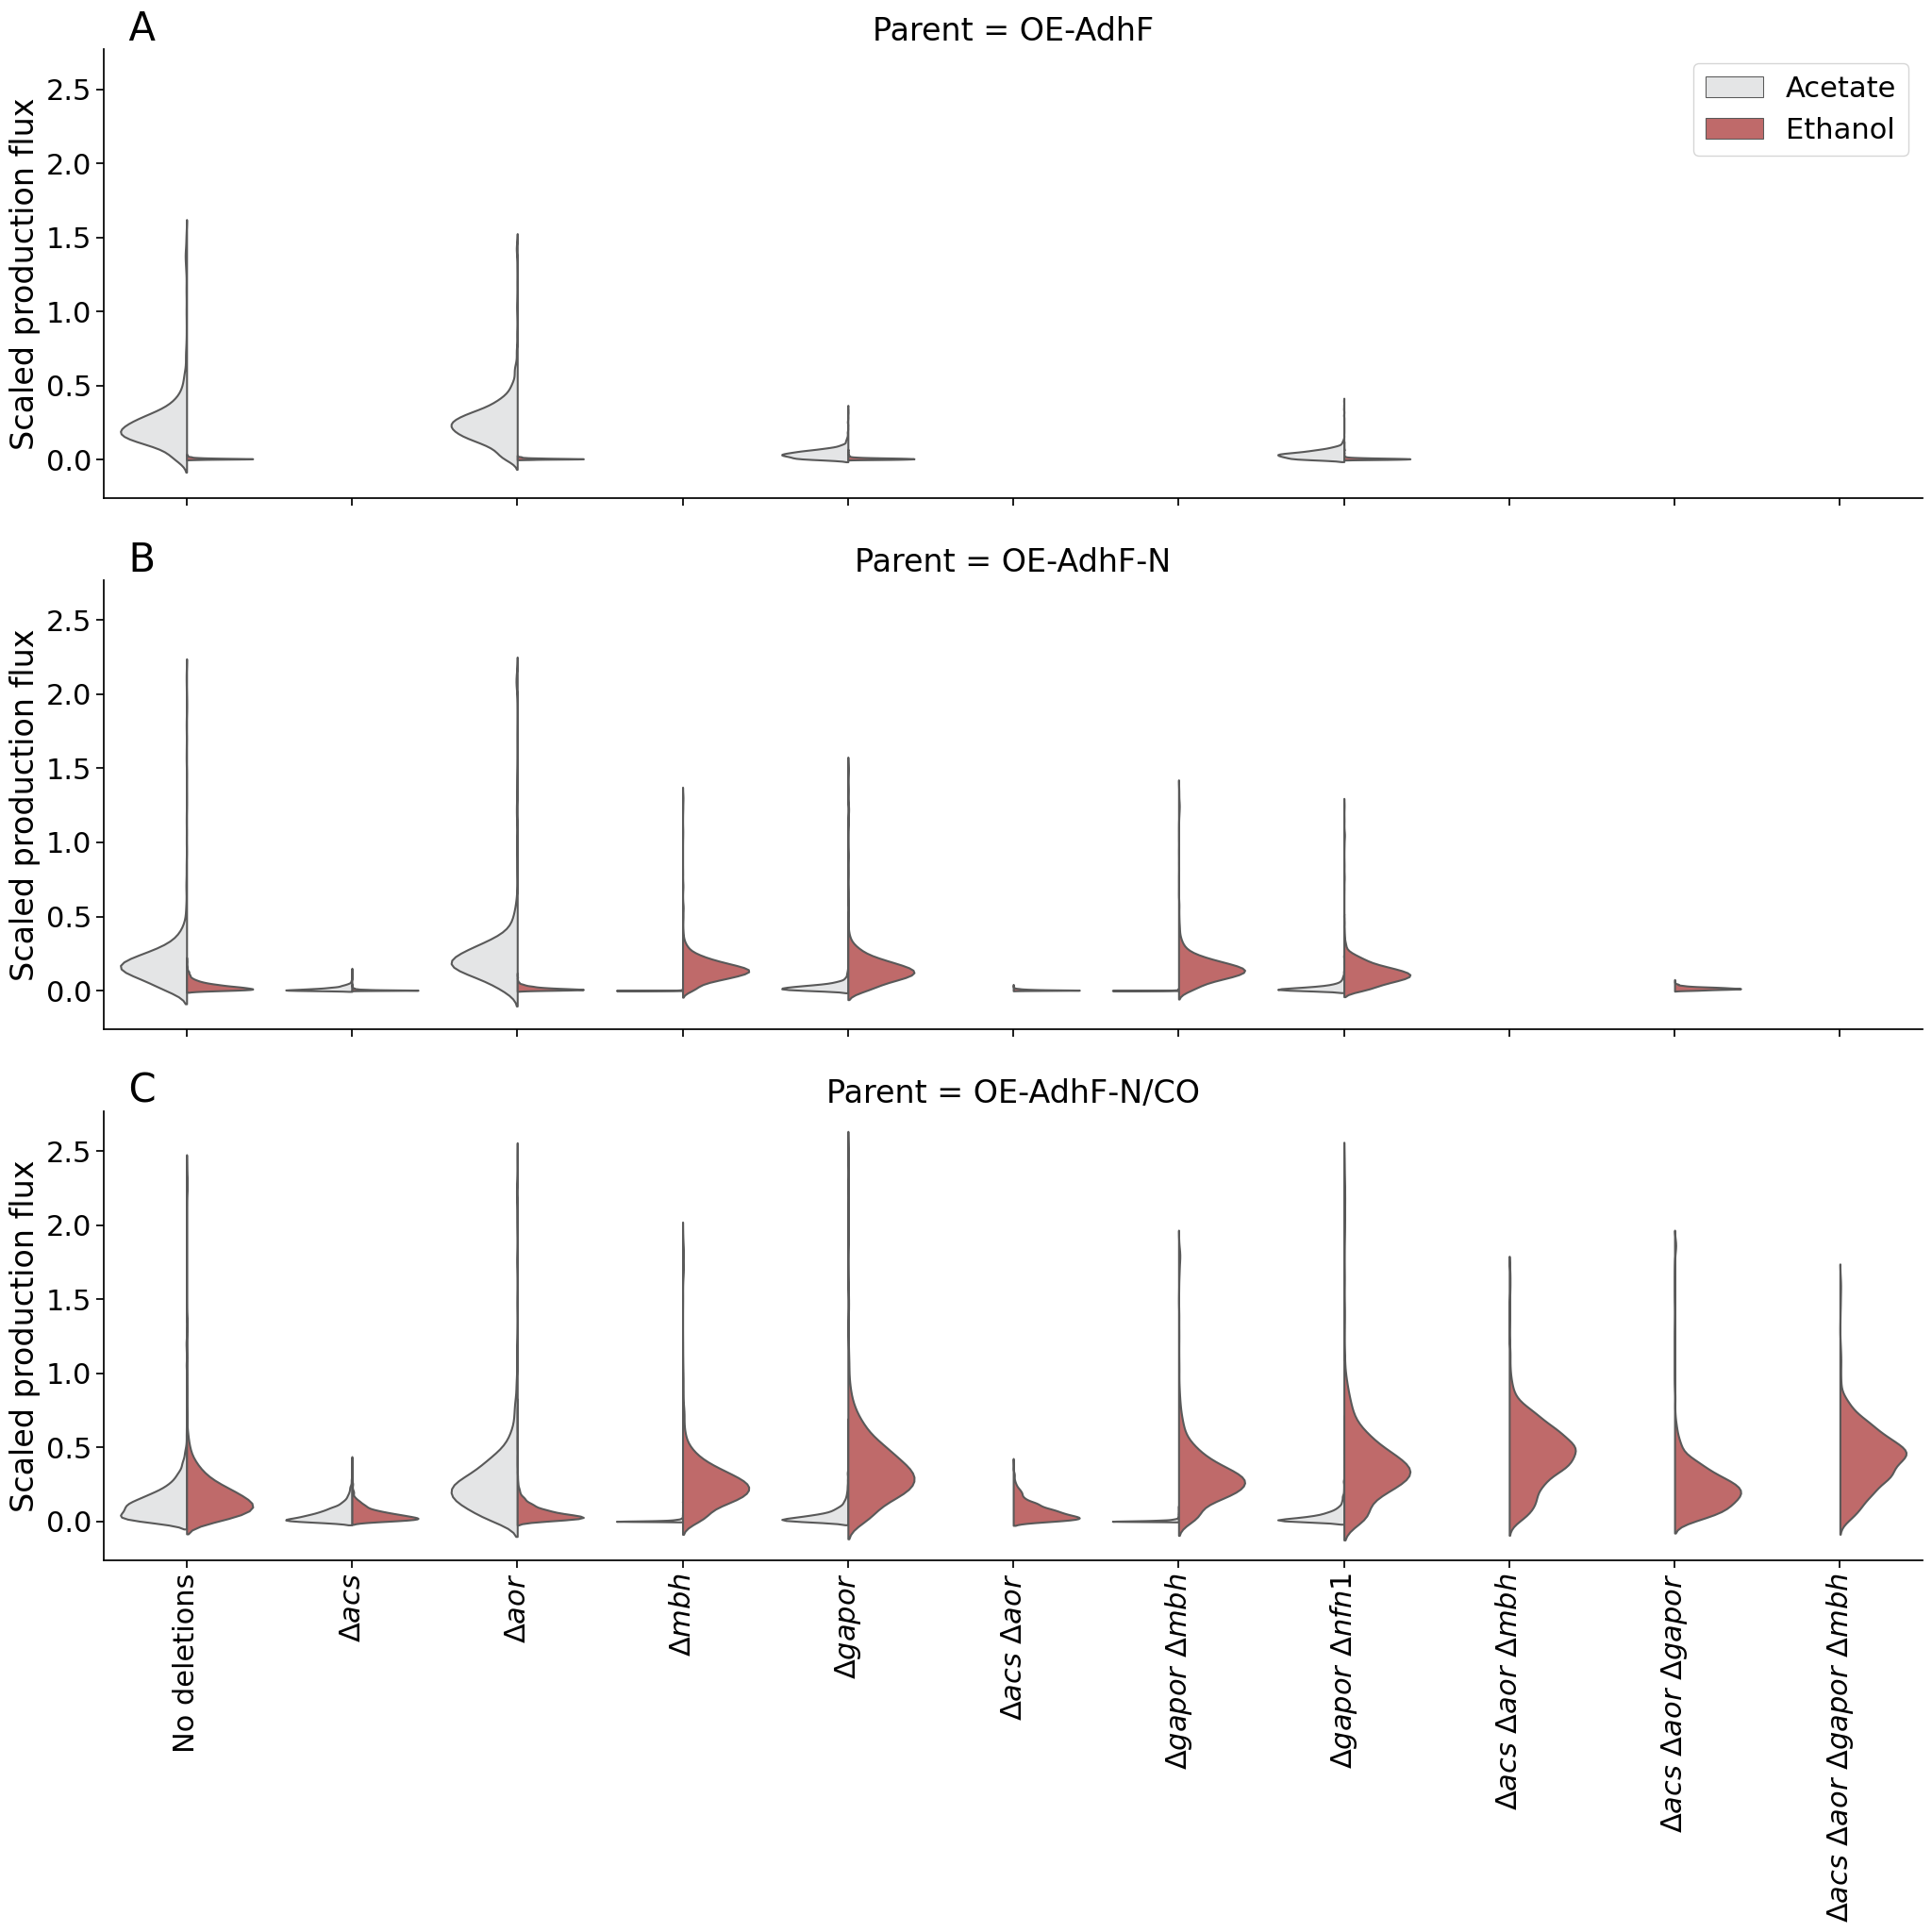

In [12]:
with sns.plotting_context("notebook", font_scale=2):
    g = sns.FacetGrid(df_open_forfig.sort_values(by="Knockins", key=lambda x: x.str.len()), col="Knockins", col_wrap=1,
                     aspect=3, height=7)
    g.map_dataframe(sns.violinplot, x="deletions", y=yaxisname, hue="variable", hue_order=["Acetate", "Ethanol"], 
                    split=True, inner=None, scale="count", scale_hue=False, order=l, palette=sns.color_palette(["#e4e5e6", mcolors.to_hex("indianred")]))
    g.axes[0].set_title("  A", loc="left", fontdict={"fontsize": 30, "fontweight": 500})
    g.axes[0].set_title("Parent = OE-AdhF", loc="center")
    g.axes[1].set_title("  B", loc="left", fontdict={"fontsize": 30, "fontweight": 500})
    g.axes[1].set_title("Parent = OE-AdhF-N", loc="center")
    g.axes[2].set_title("  C", loc="left", fontdict={"fontsize": 30, "fontweight": 500})
    g.axes[2].set_title("Parent = OE-AdhF-N/CO", loc="center")
    g.axes[0].legend(loc="upper right")
    plt.xlabel("")
    plt.xticks(rotation="vertical")
    plt.tight_layout()
    plt.savefig("./figures/FigS3.tiff", dpi=300, format="tiff", pil_kwargs={"compression": "tiff_lzw"})
    plt.show()